In [1]:
#- import required python libraries
import netCDF4
import sys, os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import datetime
import glofrim.glofrim_lib as glib
from os.path import join, isfile, abspath, dirname, basename, normpath
from configparser import ConfigParser
from glofrim.glofrim_lib import configread
import pandas as pd

In [2]:
% matplotlib notebook
import matplotlib.tri as tri
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib
from matplotlib import cm

def make_map(nrows=1, ncols=1, figsize=(16, 6), projection=ccrs.PlateCarree()):
    subplot_kw = dict(projection=projection)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, subplot_kw=subplot_kw, sharex=True, sharey=True)
    try: # always return list
        iter(axes)
    except TypeError:
        axes = [axes]
    for ax in axes:
        gl = ax.gridlines(draw_labels=True)
        gl.xlabels_top = gl.ylabels_right = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
    return fig, axes

def plot_gtiff(ax, data, transform, cmap='viridis', vmin=None, vmax=None, cbar=False, cbar_kwargs={}, **kwargs):
    extent = plot_extent(data, transform)
    im = ax.imshow(data, extent=extent, vmin=vmin, vmax=vmax, cmap=cmap, origin='upper', **kwargs)
    ax.set_extent(extent)
    
    dmin, dmax = np.nanmin(data), np.nanmax(data)
    vmin = vmin if vmin is not None else dmin 
    vmax = vmax if vmax is not None else dmax
    if (dmax > vmax) and (dmin < vmin):
        cbar_kwargs.update(extend='both')
    elif dmax > vmax:
        cbar_kwargs.update(extend='max')
    elif dmin < vmin:
        cbar_kwargs.update(extend='min')

    if cbar:
        cbar = set_colorbar(ax, im, **cbar_kwargs)
    else:
        cbar = None
    return im, cbar

def plot_extent(data, transform):
    rows, cols = data.shape[-2:]
    left, top = transform * (0, 0)
    right, bottom = transform * (cols, rows)
    extent = (left, right, bottom, top)
    return extent

In [3]:
from glofrim import Glofrim, PCR, CMF, DFM, LFP
cbmi = Glofrim()

In [4]:
#- provide file with local paths to model objects
env_fn = r'../../environment.env'
config = configread(env_fn)
root_dir = config.get('models', 'root_dir')

In [5]:
#- convert model configs to dictionary
_cf = ConfigParser(inline_comment_prefixes=('#'))
env = glib.configread(abspath(env_fn), encoding='utf-8', cf=_cf)
glib.config2dict(env)

OrderedDict([(u'engines',
              OrderedDict([('CMF',
                            u'/home/jannis/Programmes/cama-flood_bmi_v3.6.2/src/libcama.so'),
                           ('DFM',
                            u'/home/jannis/Programmes/DFLOWFM/lib/libdflowfm.so'),
                           ('LFP',
                            u'/home/jannis/Programmes/lisflood-bmi-v5.9/liblisflood.so')])),
             (u'models',
              OrderedDict([('root_dir',
                            u'/home/jannis/PhD/code/GLOFRIMplusCAMA/model_test_data/test_Elbe')]))])

In [6]:
#- provide file with coupling settings
# config_fn = join(root_dir, 'glofrim_PCR2CMF.ini')
# config_fn = join(root_dir, 'glofrim_PCR2DFM.ini')
# config_fn = join(root_dir, 'glofrim_WFL2DFM.ini')
config_fn = join(root_dir, 'glofrim_PCR2LFP.ini')
config_fn

u'/home/jannis/PhD/code/GLOFRIMplusCAMA/model_test_data/test_Elbe/glofrim_PCR2LFP.ini'

In [7]:
#- provide locations where to extract simulated discharge
x_obs_coord = 10.89 # set to coords of Neu-Darchau
y_obs_coord = 53.23
discharge_keys = {'PCR': 'PCR.discharge', 'CMF': 'CMF.outflw', 'DFM': 'DFM.q1', 'LFP': 'LFP.SGCQin'}

In [8]:
#- create coupled GLOFRIM model and initialize configs
try:
    cbmi.initialize_config(config_fn, env_fn=env_fn)
except Exception as e:
    print e
    sys.exit('configs could not be initialized')

2018-07-25 15:28:54,798 - PCR - INFO - Config initialized
2018-07-25 15:28:54,807 - LFP - INFO - Config initialized


In [9]:
models = cbmi.bmimodels.keys()
df = pd.DataFrame(columns=models) # output dataframe
print(models)
cbmi.exchanges

['PCR', 'LFP']


[('update', 'PCR'),
 ('exchange',
  {'coupling': SpatialCoupling object from PCR to LFP based on grid_2_1d method,
   'from_mod': 'PCR',
   'from_unit': ['m/day', 'm2'],
   'from_vars': ['runoff', 'cellArea'],
   'to_mod': u'LFP',
   'to_unit': ['m3/s', 'unknown'],
   'to_vars': [u'SGCQin', 86400.0]}),
 ('update', 'LFP')]

In [10]:
# - provide start and end date
t_start = datetime(2000,5,1)
t_end = datetime(2000,12,31)
cbmi.set_start_time(t_start)
cbmi.set_end_time(t_end)
print cbmi.get_start_time()
print cbmi.get_end_time()
try:
    t_start == cbmi.get_start_time()
    t_end == cbmi.get_end_time()
except:
    sys.exit('start or end time differ with set_var and get_var')

2000-05-01 00:00:00
2000-12-31 00:00:00


In [11]:
#- create coupled GLOFRIM model and initialize models
try:
    cbmi.initialize_model()
except Exception as e:
    print e
    sys.exit('models could not be initialized')

2018-07-25 15:28:54,994 - PCR - INFO - Getting rgrid info based on landmask_elbe_30min.map
2018-07-25 15:28:54,997 - PCR - INFO - Getting drainage direction from ldd_elbe_30min.map
2018-07-25 15:28:54,999 - LFP - INFO - Getting rgrid info based on LFP_Elbe_DEM_2km.asc
2018-07-25 15:28:55,062 - PCR - WARNING - /home/jannis/PhD/code/GLOFRIMplusCAMA/model_test_data/test_Elbe/PCR_Elbe/setup_PCR_30min_Elbe_glofrim.ini file overwritten
2018-07-25 15:28:55,064 - PCR - INFO - Ini file written to /home/jannis/PhD/code/GLOFRIMplusCAMA/model_test_data/test_Elbe/PCR_Elbe/setup_PCR_30min_Elbe_glofrim.ini
2018-07-25 15:28:55,068 pcrglobwb_bmi_v203.configuration INFO Model run started at 2018-07-25 15:28:55.065166
2018-07-25 15:28:55,070 pcrglobwb_bmi_v203.configuration INFO Logging output to /home/jannis/PhD/code/GLOFRIMplusCAMA/experiment_GLOFRIM2/PCR/log/setup_PCR_30min_Elbe.ini_2018-07-25T15:28:55.065166.log
2018-07-25 15:28:55,071 pcrglobwb_bmi_v203.configuration INFO Note that avgSurfaceWaterIn

1D nodes found outside of valid 2D domain


2018-07-25 15:28:55,378 pcrglobwb_bmi_v203.meteo INFO No forcing downscaling is implemented.
2018-07-25 15:29:03,731 pcrglobwb_bmi_v203.deterministic_runner INFO Adjusting some model parameters based on given values in the ini/configuration file.
2018-07-25 15:29:03,732 pcrglobwb_bmi_v203.deterministic_runner INFO 

Multiplier values used: 
For minSoilDepthFrac           : 1.0
For kSat (log-scale)           : 0.0
For recessionCoeff (log-scale) : 1.0
For storCap                    : 1.25
For degreeDayFactor            : 1.0
For refPotET                   : 1.0

2018-07-25 15:29:03,735 pcrglobwb_bmi_v203.pcrglobwb_bmi INFO Model initialized. Spin-up might be required.
2018-07-25 15:29:03,736 - PCR - INFO - Model initialized
2018-07-25 15:29:03,736 PCR INFO Model initialized
2018-07-25 15:29:03,739 - LFP - WARNING - /home/jannis/PhD/code/GLOFRIMplusCAMA/model_test_data/test_Elbe/LFP_data/LFPmodel_Elbe_glofrim.par file overwritten
2018-07-25 15:29:03,739 LFP WARNING /home/jannis/PhD/code/G

In [12]:
#- get corresponding indices for models
obs_ind = dict()
obs_xy = dict()
for mod in models:
    if cbmi.bmimodels[mod].grid.type == 2: # assume 1d for ugrid
        obs_ind[mod] = cbmi.index(x_obs_coord, y_obs_coord, mod, in1d=True)
        obs_xy[mod] = cbmi.bmimodels[mod].grid._1d.xy(ind=obs_ind[mod]).squeeze()
    else: 
        obs_ind[mod] = cbmi.index(x_obs_coord, y_obs_coord, mod, in1d=False)
        obs_xy[mod] = cbmi.bmimodels[mod].grid.xy(ind=obs_ind[mod]) # not for ugrid
obs_ind, obs_xy

({'LFP': array([8900]), 'PCR': array([67])},
 {'LFP': (array([ 10.90091533]), array([ 53.22593])),
  'PCR': (array([ 10.75]), array([ 53.25]))})

In [13]:
# cbmi.get_start_time(), cbmi.get_current_time(), cbmi.get_end_time()

In [14]:
print 'start time in '+ models[0] + ' is '+ str(cbmi.bmimodels[models[0]].get_start_time())
print 'start time in '+ models[1] + ' is '+ str(cbmi.bmimodels[models[1]].get_start_time())
print 'start time in cBMI is ' + str(cbmi.get_start_time())
print ''
print 'current time in '+ models[0] + ' is '+ str(cbmi.bmimodels[models[0]].get_current_time())
print 'current time in '+ models[1] + ' is '+ str(cbmi.bmimodels[models[1]].get_current_time())
print 'current time in cBMI is ' + str(cbmi.get_current_time())
print ''
print 'end time in '+ models[0] + ' is '+ str(cbmi.bmimodels[models[0]].get_end_time())
print 'end time in '+ models[1] + ' is '+ str(cbmi.bmimodels[models[1]].get_end_time())
print 'end end in cBMI is ' + str(cbmi.get_end_time())

if cbmi.bmimodels[models[0]].get_start_time() != cbmi.bmimodels[models[1]].get_start_time() or \
        cbmi.bmimodels[models[0]].get_current_time() != cbmi.bmimodels[models[1]].get_current_time() or \
            cbmi.bmimodels[models[0]].get_end_time() != cbmi.bmimodels[models[1]].get_end_time():
    
    sys.exit('time properties do not match between ' + models[0] + ' and ' + models[1])

start time in PCR is 2000-01-01 00:00:00
start time in LFP is 2000-05-01 00:00:00
start time in cBMI is 2000-05-01 00:00:00

current time in PCR is 2000-01-01 00:00:00
current time in LFP is 2000-05-01 00:00:00
current time in cBMI is 2000-01-01 00:00:00

end time in PCR is 2001-12-31 00:00:00
end time in LFP is 2001-05-01 00:00:00
end end in cBMI is 2001-05-01 00:00:00


SystemExit: time properties do not match between PCR and LFP

/home/jannis/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2886: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [15]:
# # - update models until end time is reached
# # - also, read out discharge data at specified observation point
# # print 'running simulation from ', str(cbmi.get_start_time()),' to ', str(cbmi.get_end_time())
while cbmi.get_current_time() < cbmi.get_end_time():
    t = cbmi.get_current_time()
    print t
    print cbmi.bmimodels[models[0]].get_current_time(), cbmi.bmimodels[models[1]].get_current_time()
    cbmi.update()
    for mod in models:
         df.loc[t, mod] = cbmi.get_value_at_indices(discharge_keys[mod], obs_ind[mod])[0]

2018-07-25 15:29:59,738 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-01
2018-07-25 15:29:59,929 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-01


2000-01-01 00:00:00
2000-01-01 00:00:00 2000-05-01 00:00:00


2018-07-25 15:30:01,272 - PCR - INFO - updated model to datetime 2000-01-02
2018-07-25 15:30:01,272 PCR INFO updated model to datetime 2000-01-02
2018-07-25 15:30:01,415 - LFP - INFO - updated model to datetime 2000-01-02
2018-07-25 15:30:01,415 LFP INFO updated model to datetime 2000-01-02
2018-07-25 15:30:01,422 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-02
2018-07-25 15:30:01,591 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-02


2000-01-02 00:00:00
2000-01-02 00:00:00 2000-05-01 00:08:20


2018-07-25 15:30:02,291 - PCR - INFO - updated model to datetime 2000-01-03
2018-07-25 15:30:02,291 PCR INFO updated model to datetime 2000-01-03
2018-07-25 15:30:02,296 - LFP - INFO - updated model to datetime 2000-01-03
2018-07-25 15:30:02,296 LFP INFO updated model to datetime 2000-01-03
2018-07-25 15:30:02,301 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-03
2018-07-25 15:30:02,466 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-03


2000-01-03 00:00:00
2000-01-03 00:00:00 2000-05-01 00:08:20.000002


2018-07-25 15:30:03,167 - PCR - INFO - updated model to datetime 2000-01-04
2018-07-25 15:30:03,167 PCR INFO updated model to datetime 2000-01-04
2018-07-25 15:30:03,195 - LFP - INFO - updated model to datetime 2000-01-04
2018-07-25 15:30:03,195 LFP INFO updated model to datetime 2000-01-04
2018-07-25 15:30:03,200 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-04
2018-07-25 15:30:03,364 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-04


2000-01-04 00:00:00
2000-01-04 00:00:00 2000-05-01 00:08:20.000003


2018-07-25 15:30:04,057 - PCR - INFO - updated model to datetime 2000-01-05
2018-07-25 15:30:04,057 PCR INFO updated model to datetime 2000-01-05
2018-07-25 15:30:04,078 - LFP - INFO - updated model to datetime 2000-01-05
2018-07-25 15:30:04,078 LFP INFO updated model to datetime 2000-01-05
2018-07-25 15:30:04,083 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-05
2018-07-25 15:30:04,250 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-05


2000-01-05 00:00:00
2000-01-05 00:00:00 2000-05-01 00:08:20.000005


2018-07-25 15:30:04,953 - PCR - INFO - updated model to datetime 2000-01-06
2018-07-25 15:30:04,953 PCR INFO updated model to datetime 2000-01-06
2018-07-25 15:30:04,959 - LFP - INFO - updated model to datetime 2000-01-06
2018-07-25 15:30:04,959 LFP INFO updated model to datetime 2000-01-06
2018-07-25 15:30:04,963 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-06
2018-07-25 15:30:05,127 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-06


2000-01-06 00:00:00
2000-01-06 00:00:00 2000-05-01 00:08:20.000006


2018-07-25 15:30:05,828 - PCR - INFO - updated model to datetime 2000-01-07
2018-07-25 15:30:05,828 PCR INFO updated model to datetime 2000-01-07
2018-07-25 15:30:05,833 - LFP - INFO - updated model to datetime 2000-01-07
2018-07-25 15:30:05,833 LFP INFO updated model to datetime 2000-01-07
2018-07-25 15:30:05,838 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-07
2018-07-25 15:30:06,000 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-07


2000-01-07 00:00:00
2000-01-07 00:00:00 2000-05-01 00:08:20.000008


2018-07-25 15:30:06,700 - PCR - INFO - updated model to datetime 2000-01-08
2018-07-25 15:30:06,700 PCR INFO updated model to datetime 2000-01-08
2018-07-25 15:30:06,728 - LFP - INFO - updated model to datetime 2000-01-08
2018-07-25 15:30:06,728 LFP INFO updated model to datetime 2000-01-08
2018-07-25 15:30:06,734 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-08
2018-07-25 15:30:06,898 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-08


2000-01-08 00:00:00
2000-01-08 00:00:00 2000-05-01 00:08:20.000010


2018-07-25 15:30:07,593 - PCR - INFO - updated model to datetime 2000-01-09
2018-07-25 15:30:07,593 PCR INFO updated model to datetime 2000-01-09
2018-07-25 15:30:07,619 - LFP - INFO - updated model to datetime 2000-01-09
2018-07-25 15:30:07,619 LFP INFO updated model to datetime 2000-01-09
2018-07-25 15:30:07,625 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-09
2018-07-25 15:30:07,792 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-09


2000-01-09 00:00:00
2000-01-09 00:00:00 2000-05-01 00:08:20.000011


2018-07-25 15:30:08,491 - PCR - INFO - updated model to datetime 2000-01-10
2018-07-25 15:30:08,491 PCR INFO updated model to datetime 2000-01-10
2018-07-25 15:30:08,510 - LFP - INFO - updated model to datetime 2000-01-10
2018-07-25 15:30:08,510 LFP INFO updated model to datetime 2000-01-10
2018-07-25 15:30:08,515 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-10
2018-07-25 15:30:08,683 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-10


2000-01-10 00:00:00
2000-01-10 00:00:00 2000-05-01 00:08:20.000013


2018-07-25 15:30:09,384 - PCR - INFO - updated model to datetime 2000-01-11
2018-07-25 15:30:09,384 PCR INFO updated model to datetime 2000-01-11
2018-07-25 15:30:09,402 - LFP - INFO - updated model to datetime 2000-01-11
2018-07-25 15:30:09,402 LFP INFO updated model to datetime 2000-01-11
2018-07-25 15:30:09,408 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-11
2018-07-25 15:30:09,570 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-11


2000-01-11 00:00:00
2000-01-11 00:00:00 2000-05-01 00:08:20.000015


2018-07-25 15:30:10,275 - PCR - INFO - updated model to datetime 2000-01-12
2018-07-25 15:30:10,275 PCR INFO updated model to datetime 2000-01-12
2018-07-25 15:30:10,303 - LFP - INFO - updated model to datetime 2000-01-12
2018-07-25 15:30:10,303 LFP INFO updated model to datetime 2000-01-12
2018-07-25 15:30:10,308 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-12
2018-07-25 15:30:10,476 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-12


2000-01-12 00:00:00
2000-01-12 00:00:00 2000-05-01 00:08:20.000016


2018-07-25 15:30:11,182 - PCR - INFO - updated model to datetime 2000-01-13
2018-07-25 15:30:11,182 PCR INFO updated model to datetime 2000-01-13
2018-07-25 15:30:11,188 - LFP - INFO - updated model to datetime 2000-01-13
2018-07-25 15:30:11,188 LFP INFO updated model to datetime 2000-01-13
2018-07-25 15:30:11,193 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-13
2018-07-25 15:30:11,364 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-13


2000-01-13 00:00:00
2000-01-13 00:00:00 2000-05-01 00:08:20.000018


2018-07-25 15:30:12,068 - PCR - INFO - updated model to datetime 2000-01-14
2018-07-25 15:30:12,068 PCR INFO updated model to datetime 2000-01-14
2018-07-25 15:30:12,097 - LFP - INFO - updated model to datetime 2000-01-14
2018-07-25 15:30:12,097 LFP INFO updated model to datetime 2000-01-14
2018-07-25 15:30:12,102 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-14
2018-07-25 15:30:12,271 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-14


2000-01-14 00:00:00
2000-01-14 00:00:00 2000-05-01 00:08:20.000020


2018-07-25 15:30:12,983 - PCR - INFO - updated model to datetime 2000-01-15
2018-07-25 15:30:12,983 PCR INFO updated model to datetime 2000-01-15
2018-07-25 15:30:12,989 - LFP - INFO - updated model to datetime 2000-01-15
2018-07-25 15:30:12,989 LFP INFO updated model to datetime 2000-01-15
2018-07-25 15:30:12,993 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-15
2018-07-25 15:30:13,158 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-15


2000-01-15 00:00:00
2000-01-15 00:00:00 2000-05-01 00:08:20.000021


2018-07-25 15:30:13,859 - PCR - INFO - updated model to datetime 2000-01-16
2018-07-25 15:30:13,859 PCR INFO updated model to datetime 2000-01-16
2018-07-25 15:30:13,887 - LFP - INFO - updated model to datetime 2000-01-16
2018-07-25 15:30:13,887 LFP INFO updated model to datetime 2000-01-16
2018-07-25 15:30:13,892 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-16
2018-07-25 15:30:14,058 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-16


2000-01-16 00:00:00
2000-01-16 00:00:00 2000-05-01 00:08:20.000023


2018-07-25 15:30:14,759 - PCR - INFO - updated model to datetime 2000-01-17
2018-07-25 15:30:14,759 PCR INFO updated model to datetime 2000-01-17
2018-07-25 15:30:14,782 - LFP - INFO - updated model to datetime 2000-01-17
2018-07-25 15:30:14,782 LFP INFO updated model to datetime 2000-01-17
2018-07-25 15:30:14,787 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-17
2018-07-25 15:30:14,955 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-17


2000-01-17 00:00:00
2000-01-17 00:00:00 2000-05-01 00:08:20.000025


2018-07-25 15:30:15,655 - PCR - INFO - updated model to datetime 2000-01-18
2018-07-25 15:30:15,655 PCR INFO updated model to datetime 2000-01-18
2018-07-25 15:30:15,683 - LFP - INFO - updated model to datetime 2000-01-18
2018-07-25 15:30:15,683 LFP INFO updated model to datetime 2000-01-18
2018-07-25 15:30:15,688 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-18
2018-07-25 15:30:15,852 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-18


2000-01-18 00:00:00
2000-01-18 00:00:00 2000-05-01 00:08:20.000027


2018-07-25 15:30:16,544 - PCR - INFO - updated model to datetime 2000-01-19
2018-07-25 15:30:16,544 PCR INFO updated model to datetime 2000-01-19
2018-07-25 15:30:16,572 - LFP - INFO - updated model to datetime 2000-01-19
2018-07-25 15:30:16,572 LFP INFO updated model to datetime 2000-01-19
2018-07-25 15:30:16,577 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-19
2018-07-25 15:30:16,739 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-19


2000-01-19 00:00:00
2000-01-19 00:00:00 2000-05-01 00:08:20.000029


2018-07-25 15:30:17,433 - PCR - INFO - updated model to datetime 2000-01-20
2018-07-25 15:30:17,433 PCR INFO updated model to datetime 2000-01-20
2018-07-25 15:30:17,440 - LFP - INFO - updated model to datetime 2000-01-20
2018-07-25 15:30:17,440 LFP INFO updated model to datetime 2000-01-20
2018-07-25 15:30:17,444 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-20
2018-07-25 15:30:17,612 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-20


2000-01-20 00:00:00
2000-01-20 00:00:00 2000-05-01 00:08:20.000031


2018-07-25 15:30:18,314 - PCR - INFO - updated model to datetime 2000-01-21
2018-07-25 15:30:18,314 PCR INFO updated model to datetime 2000-01-21
2018-07-25 15:30:18,319 - LFP - INFO - updated model to datetime 2000-01-21
2018-07-25 15:30:18,319 LFP INFO updated model to datetime 2000-01-21
2018-07-25 15:30:18,324 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-21
2018-07-25 15:30:18,486 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-21


2000-01-21 00:00:00
2000-01-21 00:00:00 2000-05-01 00:08:20.000032


2018-07-25 15:30:19,174 - PCR - INFO - updated model to datetime 2000-01-22
2018-07-25 15:30:19,174 PCR INFO updated model to datetime 2000-01-22
2018-07-25 15:30:19,203 - LFP - INFO - updated model to datetime 2000-01-22
2018-07-25 15:30:19,203 LFP INFO updated model to datetime 2000-01-22
2018-07-25 15:30:19,208 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-22
2018-07-25 15:30:19,375 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-22


2000-01-22 00:00:00
2000-01-22 00:00:00 2000-05-01 00:08:20.000034


2018-07-25 15:30:20,075 - PCR - INFO - updated model to datetime 2000-01-23
2018-07-25 15:30:20,075 PCR INFO updated model to datetime 2000-01-23
2018-07-25 15:30:20,106 - LFP - INFO - updated model to datetime 2000-01-23
2018-07-25 15:30:20,106 LFP INFO updated model to datetime 2000-01-23
2018-07-25 15:30:20,111 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-23
2018-07-25 15:30:20,274 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-23


2000-01-23 00:00:00
2000-01-23 00:00:00 2000-05-01 00:08:20.000036


2018-07-25 15:30:20,975 - PCR - INFO - updated model to datetime 2000-01-24
2018-07-25 15:30:20,975 PCR INFO updated model to datetime 2000-01-24
2018-07-25 15:30:20,998 - LFP - INFO - updated model to datetime 2000-01-24
2018-07-25 15:30:20,998 LFP INFO updated model to datetime 2000-01-24
2018-07-25 15:30:21,003 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-24
2018-07-25 15:30:21,173 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-24


2000-01-24 00:00:00
2000-01-24 00:00:00 2000-05-01 00:08:20.000038


2018-07-25 15:30:21,876 - PCR - INFO - updated model to datetime 2000-01-25
2018-07-25 15:30:21,876 PCR INFO updated model to datetime 2000-01-25
2018-07-25 15:30:21,904 - LFP - INFO - updated model to datetime 2000-01-25
2018-07-25 15:30:21,904 LFP INFO updated model to datetime 2000-01-25
2018-07-25 15:30:21,909 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-25
2018-07-25 15:30:22,082 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-25


2000-01-25 00:00:00
2000-01-25 00:00:00 2000-05-01 00:08:20.000041


2018-07-25 15:30:22,794 - PCR - INFO - updated model to datetime 2000-01-26
2018-07-25 15:30:22,794 PCR INFO updated model to datetime 2000-01-26
2018-07-25 15:30:22,821 - LFP - INFO - updated model to datetime 2000-01-26
2018-07-25 15:30:22,821 LFP INFO updated model to datetime 2000-01-26
2018-07-25 15:30:22,826 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-26
2018-07-25 15:30:22,998 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-26


2000-01-26 00:00:00
2000-01-26 00:00:00 2000-05-01 00:08:20.000043


2018-07-25 15:30:23,706 - PCR - INFO - updated model to datetime 2000-01-27
2018-07-25 15:30:23,706 PCR INFO updated model to datetime 2000-01-27
2018-07-25 15:30:23,735 - LFP - INFO - updated model to datetime 2000-01-27
2018-07-25 15:30:23,735 LFP INFO updated model to datetime 2000-01-27
2018-07-25 15:30:23,740 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-27
2018-07-25 15:30:23,914 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-27


2000-01-27 00:00:00
2000-01-27 00:00:00 2000-05-01 00:08:20.000045


2018-07-25 15:30:24,633 - PCR - INFO - updated model to datetime 2000-01-28
2018-07-25 15:30:24,633 PCR INFO updated model to datetime 2000-01-28
2018-07-25 15:30:24,662 - LFP - INFO - updated model to datetime 2000-01-28
2018-07-25 15:30:24,662 LFP INFO updated model to datetime 2000-01-28
2018-07-25 15:30:24,667 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-28
2018-07-25 15:30:24,836 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-28


2000-01-28 00:00:00
2000-01-28 00:00:00 2000-05-01 00:08:20.000047


2018-07-25 15:30:25,547 - PCR - INFO - updated model to datetime 2000-01-29
2018-07-25 15:30:25,547 PCR INFO updated model to datetime 2000-01-29
2018-07-25 15:30:25,576 - LFP - INFO - updated model to datetime 2000-01-29
2018-07-25 15:30:25,576 LFP INFO updated model to datetime 2000-01-29
2018-07-25 15:30:25,581 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-29
2018-07-25 15:30:25,749 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-29


2000-01-29 00:00:00
2000-01-29 00:00:00 2000-05-01 00:08:20.000049


2018-07-25 15:30:26,462 - PCR - INFO - updated model to datetime 2000-01-30
2018-07-25 15:30:26,462 PCR INFO updated model to datetime 2000-01-30
2018-07-25 15:30:26,490 - LFP - INFO - updated model to datetime 2000-01-30
2018-07-25 15:30:26,490 LFP INFO updated model to datetime 2000-01-30
2018-07-25 15:30:26,496 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-30
2018-07-25 15:30:26,660 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-30


2000-01-30 00:00:00
2000-01-30 00:00:00 2000-05-01 00:08:20.000052


2018-07-25 15:30:27,366 - PCR - INFO - updated model to datetime 2000-01-31
2018-07-25 15:30:27,366 PCR INFO updated model to datetime 2000-01-31
2018-07-25 15:30:27,372 - LFP - INFO - updated model to datetime 2000-01-31
2018-07-25 15:30:27,372 LFP INFO updated model to datetime 2000-01-31
2018-07-25 15:30:27,377 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-31
2018-07-25 15:30:27,540 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-31


2000-01-31 00:00:00
2000-01-31 00:00:00 2000-05-01 00:08:20.000054


2018-07-25 15:30:28,245 - PCR - INFO - updated model to datetime 2000-02-01
2018-07-25 15:30:28,245 PCR INFO updated model to datetime 2000-02-01
2018-07-25 15:30:28,267 - LFP - INFO - updated model to datetime 2000-02-01
2018-07-25 15:30:28,267 LFP INFO updated model to datetime 2000-02-01
2018-07-25 15:30:28,272 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-01
2018-07-25 15:30:28,443 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-01


2000-02-01 00:00:00
2000-02-01 00:00:00 2000-05-01 00:08:20.000056


2018-07-25 15:30:29,332 - PCR - INFO - updated model to datetime 2000-02-02
2018-07-25 15:30:29,332 PCR INFO updated model to datetime 2000-02-02
2018-07-25 15:30:29,351 - LFP - INFO - updated model to datetime 2000-02-02
2018-07-25 15:30:29,351 LFP INFO updated model to datetime 2000-02-02
2018-07-25 15:30:29,356 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-02
2018-07-25 15:30:29,528 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-02


2000-02-02 00:00:00
2000-02-02 00:00:00 2000-05-01 00:08:20.000058


2018-07-25 15:30:30,235 - PCR - INFO - updated model to datetime 2000-02-03
2018-07-25 15:30:30,235 PCR INFO updated model to datetime 2000-02-03
2018-07-25 15:30:30,253 - LFP - INFO - updated model to datetime 2000-02-03
2018-07-25 15:30:30,253 LFP INFO updated model to datetime 2000-02-03
2018-07-25 15:30:30,258 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-03
2018-07-25 15:30:30,425 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-03


2000-02-03 00:00:00
2000-02-03 00:00:00 2000-05-01 00:08:20.000061


2018-07-25 15:30:31,143 - PCR - INFO - updated model to datetime 2000-02-04
2018-07-25 15:30:31,143 PCR INFO updated model to datetime 2000-02-04
2018-07-25 15:30:31,172 - LFP - INFO - updated model to datetime 2000-02-04
2018-07-25 15:30:31,172 LFP INFO updated model to datetime 2000-02-04
2018-07-25 15:30:31,177 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-04
2018-07-25 15:30:31,343 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-04


2000-02-04 00:00:00
2000-02-04 00:00:00 2000-05-01 00:08:20.000063


2018-07-25 15:30:32,041 - PCR - INFO - updated model to datetime 2000-02-05
2018-07-25 15:30:32,041 PCR INFO updated model to datetime 2000-02-05
2018-07-25 15:30:32,069 - LFP - INFO - updated model to datetime 2000-02-05
2018-07-25 15:30:32,069 LFP INFO updated model to datetime 2000-02-05
2018-07-25 15:30:32,074 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-05
2018-07-25 15:30:32,246 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-05


2000-02-05 00:00:00
2000-02-05 00:00:00 2000-05-01 00:08:20.000066


2018-07-25 15:30:32,964 - PCR - INFO - updated model to datetime 2000-02-06
2018-07-25 15:30:32,964 PCR INFO updated model to datetime 2000-02-06
2018-07-25 15:30:32,992 - LFP - INFO - updated model to datetime 2000-02-06
2018-07-25 15:30:32,992 LFP INFO updated model to datetime 2000-02-06
2018-07-25 15:30:32,997 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-06
2018-07-25 15:30:33,160 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-06


2000-02-06 00:00:00
2000-02-06 00:00:00 2000-05-01 00:08:20.000069


2018-07-25 15:30:33,865 - PCR - INFO - updated model to datetime 2000-02-07
2018-07-25 15:30:33,865 PCR INFO updated model to datetime 2000-02-07
2018-07-25 15:30:33,893 - LFP - INFO - updated model to datetime 2000-02-07
2018-07-25 15:30:33,893 LFP INFO updated model to datetime 2000-02-07
2018-07-25 15:30:33,898 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-07
2018-07-25 15:30:34,068 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-07


2000-02-07 00:00:00
2000-02-07 00:00:00 2000-05-01 00:08:20.000071


2018-07-25 15:30:34,773 - PCR - INFO - updated model to datetime 2000-02-08
2018-07-25 15:30:34,773 PCR INFO updated model to datetime 2000-02-08
2018-07-25 15:30:34,783 - LFP - INFO - updated model to datetime 2000-02-08
2018-07-25 15:30:34,783 LFP INFO updated model to datetime 2000-02-08
2018-07-25 15:30:34,788 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-08
2018-07-25 15:30:34,959 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-08


2000-02-08 00:00:00
2000-02-08 00:00:00 2000-05-01 00:08:20.000074


2018-07-25 15:30:35,670 - PCR - INFO - updated model to datetime 2000-02-09
2018-07-25 15:30:35,670 PCR INFO updated model to datetime 2000-02-09
2018-07-25 15:30:35,698 - LFP - INFO - updated model to datetime 2000-02-09
2018-07-25 15:30:35,698 LFP INFO updated model to datetime 2000-02-09
2018-07-25 15:30:35,703 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-09
2018-07-25 15:30:35,876 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-09


2000-02-09 00:00:00
2000-02-09 00:00:00 2000-05-01 00:08:20.000077


2018-07-25 15:30:36,580 - PCR - INFO - updated model to datetime 2000-02-10
2018-07-25 15:30:36,580 PCR INFO updated model to datetime 2000-02-10
2018-07-25 15:30:36,609 - LFP - INFO - updated model to datetime 2000-02-10
2018-07-25 15:30:36,609 LFP INFO updated model to datetime 2000-02-10
2018-07-25 15:30:36,614 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-10
2018-07-25 15:30:36,784 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-10


2000-02-10 00:00:00
2000-02-10 00:00:00 2000-05-01 00:08:20.000079


2018-07-25 15:30:37,504 - PCR - INFO - updated model to datetime 2000-02-11
2018-07-25 15:30:37,504 PCR INFO updated model to datetime 2000-02-11
2018-07-25 15:30:37,526 - LFP - INFO - updated model to datetime 2000-02-11
2018-07-25 15:30:37,526 LFP INFO updated model to datetime 2000-02-11
2018-07-25 15:30:37,531 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-11
2018-07-25 15:30:37,694 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-11


2000-02-11 00:00:00
2000-02-11 00:00:00 2000-05-01 00:08:20.000082


2018-07-25 15:30:38,395 - PCR - INFO - updated model to datetime 2000-02-12
2018-07-25 15:30:38,395 PCR INFO updated model to datetime 2000-02-12
2018-07-25 15:30:38,401 - LFP - INFO - updated model to datetime 2000-02-12
2018-07-25 15:30:38,401 LFP INFO updated model to datetime 2000-02-12
2018-07-25 15:30:38,406 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-12
2018-07-25 15:30:38,574 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-12


2000-02-12 00:00:00
2000-02-12 00:00:00 2000-05-01 00:08:20.000084


2018-07-25 15:30:39,290 - PCR - INFO - updated model to datetime 2000-02-13
2018-07-25 15:30:39,290 PCR INFO updated model to datetime 2000-02-13
2018-07-25 15:30:39,295 - LFP - INFO - updated model to datetime 2000-02-13
2018-07-25 15:30:39,295 LFP INFO updated model to datetime 2000-02-13
2018-07-25 15:30:39,302 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-13
2018-07-25 15:30:39,473 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-13


2000-02-13 00:00:00
2000-02-13 00:00:00 2000-05-01 00:08:20.000087


2018-07-25 15:30:40,181 - PCR - INFO - updated model to datetime 2000-02-14
2018-07-25 15:30:40,181 PCR INFO updated model to datetime 2000-02-14
2018-07-25 15:30:40,202 - LFP - INFO - updated model to datetime 2000-02-14
2018-07-25 15:30:40,202 LFP INFO updated model to datetime 2000-02-14
2018-07-25 15:30:40,208 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-14
2018-07-25 15:30:40,377 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-14


2000-02-14 00:00:00
2000-02-14 00:00:00 2000-05-01 00:08:20.000090


2018-07-25 15:30:41,088 - PCR - INFO - updated model to datetime 2000-02-15
2018-07-25 15:30:41,088 PCR INFO updated model to datetime 2000-02-15
2018-07-25 15:30:41,117 - LFP - INFO - updated model to datetime 2000-02-15
2018-07-25 15:30:41,117 LFP INFO updated model to datetime 2000-02-15
2018-07-25 15:30:41,122 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-15
2018-07-25 15:30:41,295 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-15


2000-02-15 00:00:00
2000-02-15 00:00:00 2000-05-01 00:08:20.000093


2018-07-25 15:30:42,000 - PCR - INFO - updated model to datetime 2000-02-16
2018-07-25 15:30:42,000 PCR INFO updated model to datetime 2000-02-16
2018-07-25 15:30:42,015 - LFP - INFO - updated model to datetime 2000-02-16
2018-07-25 15:30:42,015 LFP INFO updated model to datetime 2000-02-16
2018-07-25 15:30:42,020 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-16
2018-07-25 15:30:42,196 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-16


2000-02-16 00:00:00
2000-02-16 00:00:00 2000-05-01 00:08:20.000096


2018-07-25 15:30:42,907 - PCR - INFO - updated model to datetime 2000-02-17
2018-07-25 15:30:42,907 PCR INFO updated model to datetime 2000-02-17
2018-07-25 15:30:42,936 - LFP - INFO - updated model to datetime 2000-02-17
2018-07-25 15:30:42,936 LFP INFO updated model to datetime 2000-02-17
2018-07-25 15:30:42,941 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-17
2018-07-25 15:30:43,105 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-17


2000-02-17 00:00:00
2000-02-17 00:00:00 2000-05-01 00:08:20.000099


2018-07-25 15:30:43,811 - PCR - INFO - updated model to datetime 2000-02-18
2018-07-25 15:30:43,811 PCR INFO updated model to datetime 2000-02-18
2018-07-25 15:30:43,823 - LFP - INFO - updated model to datetime 2000-02-18
2018-07-25 15:30:43,823 LFP INFO updated model to datetime 2000-02-18
2018-07-25 15:30:43,828 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-18
2018-07-25 15:30:44,001 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-18


2000-02-18 00:00:00
2000-02-18 00:00:00 2000-05-01 00:08:20.000102


2018-07-25 15:30:44,717 - PCR - INFO - updated model to datetime 2000-02-19
2018-07-25 15:30:44,717 PCR INFO updated model to datetime 2000-02-19
2018-07-25 15:30:44,746 - LFP - INFO - updated model to datetime 2000-02-19
2018-07-25 15:30:44,746 LFP INFO updated model to datetime 2000-02-19
2018-07-25 15:30:44,751 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-19
2018-07-25 15:30:44,923 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-19


2000-02-19 00:00:00
2000-02-19 00:00:00 2000-05-01 00:08:20.000105


2018-07-25 15:30:45,649 - PCR - INFO - updated model to datetime 2000-02-20
2018-07-25 15:30:45,649 PCR INFO updated model to datetime 2000-02-20
2018-07-25 15:30:45,655 - LFP - INFO - updated model to datetime 2000-02-20
2018-07-25 15:30:45,655 LFP INFO updated model to datetime 2000-02-20
2018-07-25 15:30:45,663 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-20
2018-07-25 15:30:45,832 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-20


2000-02-20 00:00:00
2000-02-20 00:00:00 2000-05-01 00:08:20.000108


2018-07-25 15:30:46,532 - PCR - INFO - updated model to datetime 2000-02-21
2018-07-25 15:30:46,532 PCR INFO updated model to datetime 2000-02-21
2018-07-25 15:30:46,544 - LFP - INFO - updated model to datetime 2000-02-21
2018-07-25 15:30:46,544 LFP INFO updated model to datetime 2000-02-21
2018-07-25 15:30:46,549 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-21
2018-07-25 15:30:46,717 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-21


2000-02-21 00:00:00
2000-02-21 00:00:00 2000-05-01 00:08:20.000111


2018-07-25 15:30:47,423 - PCR - INFO - updated model to datetime 2000-02-22
2018-07-25 15:30:47,423 PCR INFO updated model to datetime 2000-02-22
2018-07-25 15:30:47,452 - LFP - INFO - updated model to datetime 2000-02-22
2018-07-25 15:30:47,452 LFP INFO updated model to datetime 2000-02-22
2018-07-25 15:30:47,457 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-22
2018-07-25 15:30:47,628 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-22


2000-02-22 00:00:00
2000-02-22 00:00:00 2000-05-01 00:08:20.000115


2018-07-25 15:30:48,329 - PCR - INFO - updated model to datetime 2000-02-23
2018-07-25 15:30:48,329 PCR INFO updated model to datetime 2000-02-23
2018-07-25 15:30:48,336 - LFP - INFO - updated model to datetime 2000-02-23
2018-07-25 15:30:48,336 LFP INFO updated model to datetime 2000-02-23
2018-07-25 15:30:48,341 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-23
2018-07-25 15:30:48,508 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-23


2000-02-23 00:00:00
2000-02-23 00:00:00 2000-05-01 00:08:20.000118


2018-07-25 15:30:49,226 - PCR - INFO - updated model to datetime 2000-02-24
2018-07-25 15:30:49,226 PCR INFO updated model to datetime 2000-02-24
2018-07-25 15:30:49,235 - LFP - INFO - updated model to datetime 2000-02-24
2018-07-25 15:30:49,235 LFP INFO updated model to datetime 2000-02-24
2018-07-25 15:30:49,239 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-24
2018-07-25 15:30:49,407 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-24


2000-02-24 00:00:00
2000-02-24 00:00:00 2000-05-01 00:08:20.000121


2018-07-25 15:30:50,114 - PCR - INFO - updated model to datetime 2000-02-25
2018-07-25 15:30:50,114 PCR INFO updated model to datetime 2000-02-25
2018-07-25 15:30:50,119 - LFP - INFO - updated model to datetime 2000-02-25
2018-07-25 15:30:50,119 LFP INFO updated model to datetime 2000-02-25
2018-07-25 15:30:50,126 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-25
2018-07-25 15:30:50,297 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-25


2000-02-25 00:00:00
2000-02-25 00:00:00 2000-05-01 00:08:20.000124


2018-07-25 15:30:51,012 - PCR - INFO - updated model to datetime 2000-02-26
2018-07-25 15:30:51,012 PCR INFO updated model to datetime 2000-02-26
2018-07-25 15:30:51,030 - LFP - INFO - updated model to datetime 2000-02-26
2018-07-25 15:30:51,030 LFP INFO updated model to datetime 2000-02-26
2018-07-25 15:30:51,035 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-26
2018-07-25 15:30:51,200 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-26


2000-02-26 00:00:00
2000-02-26 00:00:00 2000-05-01 00:08:20.000127


2018-07-25 15:30:51,915 - PCR - INFO - updated model to datetime 2000-02-27
2018-07-25 15:30:51,915 PCR INFO updated model to datetime 2000-02-27
2018-07-25 15:30:51,945 - LFP - INFO - updated model to datetime 2000-02-27
2018-07-25 15:30:51,945 LFP INFO updated model to datetime 2000-02-27
2018-07-25 15:30:51,950 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-27
2018-07-25 15:30:52,124 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-27


2000-02-27 00:00:00
2000-02-27 00:00:00 2000-05-01 00:08:20.000131


2018-07-25 15:30:52,833 - PCR - INFO - updated model to datetime 2000-02-28
2018-07-25 15:30:52,833 PCR INFO updated model to datetime 2000-02-28
2018-07-25 15:30:52,844 - LFP - INFO - updated model to datetime 2000-02-28
2018-07-25 15:30:52,844 LFP INFO updated model to datetime 2000-02-28
2018-07-25 15:30:52,849 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-28
2018-07-25 15:30:53,022 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-28


2000-02-28 00:00:00
2000-02-28 00:00:00 2000-05-01 00:08:20.000134


2018-07-25 15:30:53,729 - PCR - INFO - updated model to datetime 2000-02-29
2018-07-25 15:30:53,729 PCR INFO updated model to datetime 2000-02-29
2018-07-25 15:30:53,759 - LFP - INFO - updated model to datetime 2000-02-29
2018-07-25 15:30:53,759 LFP INFO updated model to datetime 2000-02-29
2018-07-25 15:30:53,764 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-29
2018-07-25 15:30:53,936 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-29


2000-02-29 00:00:00
2000-02-29 00:00:00 2000-05-01 00:08:20.000137


2018-07-25 15:30:54,651 - PCR - INFO - updated model to datetime 2000-03-01
2018-07-25 15:30:54,651 PCR INFO updated model to datetime 2000-03-01
2018-07-25 15:30:54,679 - LFP - INFO - updated model to datetime 2000-03-01
2018-07-25 15:30:54,679 LFP INFO updated model to datetime 2000-03-01
2018-07-25 15:30:54,684 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-01
2018-07-25 15:30:54,854 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-01


2000-03-01 00:00:00
2000-03-01 00:00:00 2000-05-01 00:08:20.000140


2018-07-25 15:30:55,745 - PCR - INFO - updated model to datetime 2000-03-02
2018-07-25 15:30:55,745 PCR INFO updated model to datetime 2000-03-02
2018-07-25 15:30:55,762 - LFP - INFO - updated model to datetime 2000-03-02
2018-07-25 15:30:55,762 LFP INFO updated model to datetime 2000-03-02
2018-07-25 15:30:55,767 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-02
2018-07-25 15:30:55,939 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-02


2000-03-02 00:00:00
2000-03-02 00:00:00 2000-05-01 00:08:20.000142


2018-07-25 15:30:56,649 - PCR - INFO - updated model to datetime 2000-03-03
2018-07-25 15:30:56,649 PCR INFO updated model to datetime 2000-03-03
2018-07-25 15:30:56,656 - LFP - INFO - updated model to datetime 2000-03-03
2018-07-25 15:30:56,656 LFP INFO updated model to datetime 2000-03-03
2018-07-25 15:30:56,662 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-03
2018-07-25 15:30:56,829 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-03


2000-03-03 00:00:00
2000-03-03 00:00:00 2000-05-01 00:08:20.000146


2018-07-25 15:30:57,536 - PCR - INFO - updated model to datetime 2000-03-04
2018-07-25 15:30:57,536 PCR INFO updated model to datetime 2000-03-04
2018-07-25 15:30:57,564 - LFP - INFO - updated model to datetime 2000-03-04
2018-07-25 15:30:57,564 LFP INFO updated model to datetime 2000-03-04
2018-07-25 15:30:57,569 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-04
2018-07-25 15:30:57,745 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-04


2000-03-04 00:00:00
2000-03-04 00:00:00 2000-05-01 00:08:20.000148


2018-07-25 15:30:58,452 - PCR - INFO - updated model to datetime 2000-03-05
2018-07-25 15:30:58,452 PCR INFO updated model to datetime 2000-03-05
2018-07-25 15:30:58,480 - LFP - INFO - updated model to datetime 2000-03-05
2018-07-25 15:30:58,480 LFP INFO updated model to datetime 2000-03-05
2018-07-25 15:30:58,485 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-05
2018-07-25 15:30:58,653 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-05


2000-03-05 00:00:00
2000-03-05 00:00:00 2000-05-01 00:08:20.000152


2018-07-25 15:30:59,371 - PCR - INFO - updated model to datetime 2000-03-06
2018-07-25 15:30:59,371 PCR INFO updated model to datetime 2000-03-06
2018-07-25 15:30:59,400 - LFP - INFO - updated model to datetime 2000-03-06
2018-07-25 15:30:59,400 LFP INFO updated model to datetime 2000-03-06
2018-07-25 15:30:59,404 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-06
2018-07-25 15:30:59,577 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-06


2000-03-06 00:00:00
2000-03-06 00:00:00 2000-05-01 00:08:20.000155


2018-07-25 15:31:00,293 - PCR - INFO - updated model to datetime 2000-03-07
2018-07-25 15:31:00,293 PCR INFO updated model to datetime 2000-03-07
2018-07-25 15:31:00,310 - LFP - INFO - updated model to datetime 2000-03-07
2018-07-25 15:31:00,310 LFP INFO updated model to datetime 2000-03-07
2018-07-25 15:31:00,316 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-07
2018-07-25 15:31:00,487 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-07


2000-03-07 00:00:00
2000-03-07 00:00:00 2000-05-01 00:08:20.000158


2018-07-25 15:31:01,207 - PCR - INFO - updated model to datetime 2000-03-08
2018-07-25 15:31:01,207 PCR INFO updated model to datetime 2000-03-08
2018-07-25 15:31:01,215 - LFP - INFO - updated model to datetime 2000-03-08
2018-07-25 15:31:01,215 LFP INFO updated model to datetime 2000-03-08
2018-07-25 15:31:01,220 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-08
2018-07-25 15:31:01,389 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-08


2000-03-08 00:00:00
2000-03-08 00:00:00 2000-05-01 00:08:20.000161


2018-07-25 15:31:02,105 - PCR - INFO - updated model to datetime 2000-03-09
2018-07-25 15:31:02,105 PCR INFO updated model to datetime 2000-03-09
2018-07-25 15:31:02,113 - LFP - INFO - updated model to datetime 2000-03-09
2018-07-25 15:31:02,113 LFP INFO updated model to datetime 2000-03-09
2018-07-25 15:31:02,118 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-09
2018-07-25 15:31:02,293 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-09


2000-03-09 00:00:00
2000-03-09 00:00:00 2000-05-01 00:08:20.000164


2018-07-25 15:31:03,004 - PCR - INFO - updated model to datetime 2000-03-10
2018-07-25 15:31:03,004 PCR INFO updated model to datetime 2000-03-10


AssertionError: 

In [16]:
if 'CMF' or 'LFP' in models:
    print df[60:91]

                PCR       LFP
2000-03-01   1288.2  0.656027
2000-03-02  1234.26   0.65028
2000-03-03  1203.47  0.644226
2000-03-04  1195.23  0.637316
2000-03-05  1205.91  0.633381
2000-03-06  1222.54  0.631137
2000-03-07  1234.24  0.629147
2000-03-08  1236.26  0.625487


In [17]:
df.tail()

,PCR,LFP
2000-03-04,1195.23,0.637316
2000-03-05,1205.91,0.633381
2000-03-06,1222.54,0.631137
2000-03-07,1234.24,0.629147
2000-03-08,1236.26,0.625487


<IPython.core.display.Javascript object>


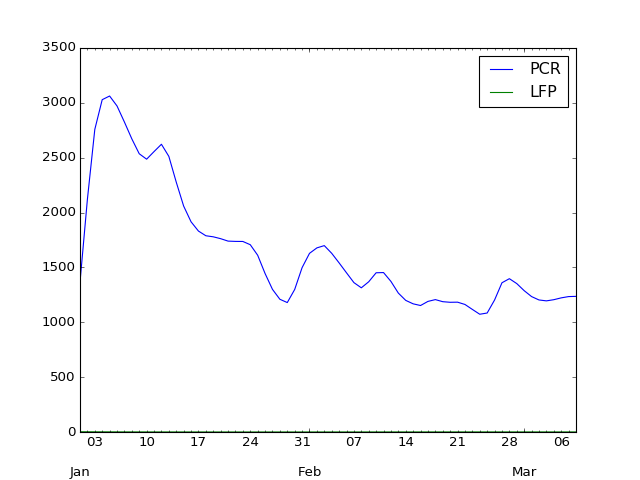

In [18]:
df.plot()

In [ ]:
# PCR_runoff = cbmi.get_value('PCR.runoff')
# CMF_roffin = cbmi.get_value("CMF.roffin")
# CMF_runoff = cbmi.get_value("CMF.runoff")

# print(np.nansum(PCR_runoff), np.nansum(CMF_roffin), np.nansum(CMF_runoff)) # 0.0056205126668403375
# #- check whether plots are correct
# plt.figure(figsize=(10,10))
# plt.subplot(131)
# plt.imshow(PCR_runoff, vmin=0, vmax=1e-2)
# plt.plot(obs_rc['PCR'][1], obs_rc['PCR'][0], '.r')
# plt.subplot(132)
# plt.imshow(CMF_roffin, vmin=0, vmax=1e-2) # this should look the same at PCR_runoff
# plt.subplot(133)
# # what is the uint of CMF_runoff ??
# plt.imshow(CMF_runoff, vmin=0, vmax=1e2) # this should look similar to PCR_runoff (after interpolation)
# plt.plot(obs_rc['CMF'][1], obs_rc['CMF'][0], '.r')

<IPython.core.display.Javascript object>


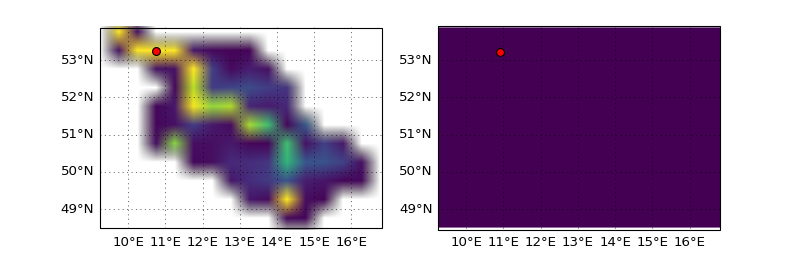

In [19]:
#- check dimensions of output maps
try: 
    fig.close()
except: 
    pass
fig, axes = make_map(ncols=len(models), figsize=(10, 3.2))
for i, mod in enumerate(models):
    vals = cbmi.get_value(discharge_keys[mod])
    if cbmi.bmimodels[mod].grid.type == 2: # assume 1d for ugrid
        coords_1d = cbmi.bmimodels[mod].grid._1d.nodes
        ind_1d = cbmi.bmimodels[mod].grid._1d.inds
        axes[i].scatter(obs_xy[mod][0], obs_xy[mod][1], c='r', s=50)
        axes[i].scatter(coords_1d[:,0], coords_1d[:,1], c=vals[ind_1d], s=0.1, vmin=0, vmax=1e3)
    else:
        plot_gtiff(axes[i], vals, cbmi.bmimodels[mod].grid.transform, vmin=0, vmax=1e3)
        axes[i].scatter(obs_xy[mod][0], obs_xy[mod][1], c='r', s=50)

<IPython.core.display.Javascript object>


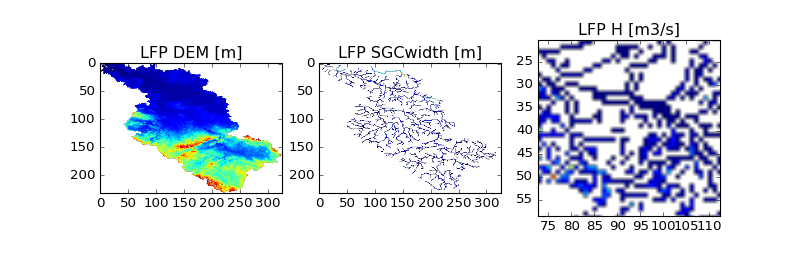

In [26]:
if 'LFP' in models:
    DEMdata = np.ma.masked_greater(cbmi.get_value('LFP.DEM'), 999)
    SGCdata = np.ma.masked_equal(cbmi.get_value('LFP.SGCwidth'), 0)
    Qxdata = np.ma.masked_equal(cbmi.get_value('LFP.H'), 0)
    plt.figure(figsize=(10, 3.2))
    plt.subplot(131)
    plt.title('LFP DEM [m]')
    plt.imshow(DEMdata)
    plt.subplot(132)
    plt.title('LFP SGCwidth [m]')
    plt.imshow(SGCdata)
    plt.subplot(133)
    plt.title('LFP H [m3/s]')
    plt.imshow(Qxdata)

In [ ]:
#- finalize all models
try:
    cbmi.finalize()
except Exception as e:
    print e
    sys.exit('models could not be finalized')